# PyRFM
__This script is an implementaion of Reflectance Field Mapping as published in ICRA 2023.__

This script is designed for readability and flexibility, and runs in a batch mode.  
Our C++ implementation demonstrates use of this in a full SLAM system, but this notebook shows only the mapping part.

# Usage

There are 3 main parts:
- *doRFM()* creates a basic reflectance field map, simply rasterizing hits and misses in (x,y,theta) space.
- *selectH()* selectively keeps glass by floodfilling RFM and finding connected components with the H shape feature defined in the paper
- *classifyReflections()* Removes lidar beams that pass "through" a known object and are likely reflected images of something else


In online mode, these three steps run constantly and interleaved. However a 3D incremental floodfill is unreadable in Python and somewhat slow.  
To get the same effect in batch mode, you run the following sequence:

    doRFM() -> selectH() -> clasifyReflections() -> doRFM() -> selectH()
   

## Example Data

This code uses input data in a deliberately trivial format. Every lidar observation specifies:

- sx,sy : the start of the ray (i.e. lidar sensor center) in the map coordinates 
- ex,ey : the endpoint of the ray
- r, th, i : original range, angle, and intensity reported by the sensor \[th, i are unused\]
- idx : the identifier of the sensor the ray is from \[unused\]
- ts : Unix timestamp of the ray \[unused\]

These are simply dumped (little endian) for every ray to a file, with sizes as specifed in the data loading cell below. Bad rays are indicated by a negative range.

Because rays are already expressed in map coodinates there is no need for cross referencing with localization, motion compensation, or other nontrivial coordinate transformations.

For our sensor, every 1081 rays corresponds to a whole scan, but you may want to change this for your code. 
The RFM is quite tolerant of incorrect scan sizes, but assumes a HIT and MISS cannot happen in the same cell within a scan, which preserves tricky corners.
    

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # progress bar

In [2]:
rayfile = "rays.rays"
data_dir = "../../data/"
raypath = data_dir+rayfile
raypath

'../../data/rays.rays'

# Hyperparameter Setting Instructions
1. CELLS_PER_M should indicate a cell width less than the max displacement of the robot between scans. 
   1. Otherwise there may be gaps between adjacent rays in the same direction.
2. Theta width should be >= laser angular spacing, and <= min peak half-width (i.e "beam divergance") at worst laser plane tilt
   1. If you can't satisfy both, mount your laser better, stiffen your suspension, or get a blurrier (higher divergence) laser!
3. Max range should be set so max_turn_rate * max_range < cell_width
4. Currently, the max distance is hardcoded at 200 cells


### HYPERPARAMTERs:

In [3]:
th_spacing = 2*np.pi/360/4 # 1/4 degree spacing from the sensor
th_bins = int(np.round(2*np.pi / th_spacing)) 
W, H = 800,1200


bias = 0
wide_threshold = 30*np.pi/180 / th_spacing
epsl = 1.

## Derived constants
# w_HIT = 3 # Reduce to 1 if known no motion
# w_MISS = 1 
# REF_BLOCK_THRESH = w_MISS/(w_MISS+w_HIT) # the theoretical way. Fraction of hits to total that means we have a reflective voxel
REF_BLOCK_THRESH = 0.3 # this is a good 

In [4]:
## Large persistent memory blocks. 
HIT = np.zeros((W,H,th_bins),'int16')
MISS = np.zeros((W,H,th_bins),'int16')
RFM = np.zeros((W,H,th_bins),'int8') # -1=TRANSPARENT, 0=UNK, 1=REFLECT
RFM_mr = np.zeros((W,H,th_bins),'int8')
WIDE = np.zeros((W,H,th_bins),'bool')
NARROW = np.zeros((W,H,th_bins),'bool')
prerender = np.zeros((W,H),'bool')
refl_cache = np.zeros((W,H),'int16')
trans_cache = np.zeros((W,H),'int16')
OCC = np.zeros((W,H),'int8')

vox_refl = np.zeros((W,H,th_bins),'float32')  
CLASSIFIED_RFM = np.zeros((W,H,th_bins),'bool')  
countvis = np.zeros((W,H),'uint16')
counttrans = np.zeros((W,H),'uint16')
countratio = np.zeros((W,H),'float32')


### Load rays:

In [5]:
rays_struct = np.dtype(
    [
        ('sx', np.float32),
        ('sy', np.float32),
        ('ex', np.float32),
        ('ey', np.float32),
        ('r' , np.float32),
        ('th', np.float32),
        ('i',  np.int32),
        ('idx',  np.int32),
        ('ts', np.float64), 
      ])
print(rays_struct)
# rays0 = np.memmap(rayfile,rays_struct, 'r',1) # if you want, you can memory map the file.
rays0 = np.fromfile(raypath, rays_struct)
print(rays0)
rays0 = rays0[:int(len(rays0)//1081*1081)]

[('sx', '<f4'), ('sy', '<f4'), ('ex', '<f4'), ('ey', '<f4'), ('r', '<f4'), ('th', '<f4'), ('i', '<i4'), ('idx', '<i4'), ('ts', '<f8')]
[(38.98473, 68.81507, 0., 0., -0.165, 0.       , -888209203, 0, 1.47939647e+09)
 (38.98473, 68.81507, 0., 0., -0.174, 0.       , -888209182, 0, 1.47939647e+09)
 (38.98473, 68.81507, 0., 0., -0.175, 0.       , -888209153, 0, 1.47939647e+09)
 ...
 (39.29727, 69.14227, 0., 0., -0.678, 1.8248912, -888206126, 1, 1.47939681e+09)
 (39.29727, 69.14227, 0., 0., -0.588, 1.8248912, -888206530, 1, 1.47939681e+09)
 (39.29727, 69.14227, 0., 0., -0.511, 1.8248912, -888207142, 1, 1.47939681e+09)]


In [6]:
## Find the max extent of the map and transforms

keep=(rays0['r']<10000)*(rays0['r']<10000)
rays=rays0[keep==1]

## Figure out rasterization
# Floor of float coords is integer coords
# Images are y flipped

def homp(T,pts):
    tmppts = pts @ T[:-1,:-1].T + T[:-1,-1]
    denom = pts @ T[-1:,:-1].T + T[-1,-1]
    return tmppts/denom


CELLS_PER_M = 20.0
print("Cell width:", 1/CELLS_PER_M)

formatter = {'float':lambda x:np.format_float_positional(x,precision=2,fractional=True,trim='-',pad_left=8,pad_right=2)}

def get_T_px_f_with_extent(rays, debug=False):
    # The corners in world space
    f_corns = np.array(
        [[np.min(rays['ex']),np.min(rays['ey'])],
         [np.max(rays['ex']),np.max(rays['ey'])]])
    T_pxc_f = np.array(
        [[1*CELLS_PER_M, 0             , 0],
         [0            , -1*CELLS_PER_M, 0],
         [0            , 0             , 1]])
    pxc_corns=homp(T_pxc_f,f_corns)
    pxc_topleft = np.array([  np.floor(np.min(pxc_corns[:,0])), np.floor(np.min(pxc_corns[:,1]))  ]) #inclusive
    pxc_btmright= np.array([  np.floor(np.max(pxc_corns[:,0])), np.floor(np.max(pxc_corns[:,1]))  ]) + 1 #exclusive
    pxc_extent = pxc_btmright-pxc_topleft

    T_px_f = T_pxc_f.copy()
    T_px_f[:-1,-1] = -pxc_topleft

    px_corns=homp(T_px_f,f_corns)
    px_topleft = np.array([  np.floor(np.min(px_corns[:,0])), np.floor(np.min(px_corns[:,1]))  ]) #inclusive
    px_btmright= np.array([  np.floor(np.max(px_corns[:,0])), np.floor(np.max(px_corns[:,1]))  ]) + 1 #exclusive
    px_extent = px_btmright-px_topleft

    assert (np.all(pxc_extent == px_extent))

    if debug:
        print("fcorns\n",f_corns)

        for var in ['pxc_corns',
                    'pxc_topleft',
                    'pxc_btmright',
                    'pxc_extent',
                    'px_corns',
                    'px_topleft',
                    'px_btmright',
                    'px_extent',
                    ]:
            print(var+'\n', eval(var))
    return T_px_f, px_extent.astype('int64')

keep_for_window=(rays0['r']>0)*(rays0['r']<10)
with np.printoptions(formatter=formatter):
    T_px_f, px_extent = get_T_px_f_with_extent(rays[keep_for_window], debug=True)

Cell width: 0.05
fcorns
 [[      28.71       12.34]
 [      70.15       76.33]]
pxc_corns
 [[     574.11     -246.81]
 [    1402.93    -1526.6 ]]
pxc_topleft
 [     574       -1527   ]
pxc_btmright
 [    1403        -246   ]
pxc_extent
 [     829        1281   ]
px_corns
 [[       0.11     1280.19]
 [     828.93        0.4 ]]
px_topleft
 [       0           0   ]
px_btmright
 [     829        1281   ]
px_extent
 [     829        1281   ]


## Convert rays to grid coodinates
This is just a scaling and offset.  
Since we computed the extent of the map in a previous cell, if you want to use a subset of the rays, but keep map extents, do it here.

# Rays to map: 23674981
Time range to map: 1479396473.584265 1479396811.672591


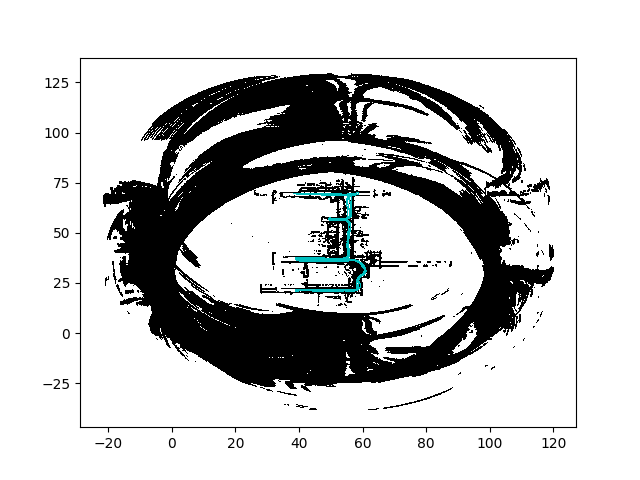

In [7]:
# # Debug show input rays
# %matplotlib widget
# plt.plot(rays0['ex'],rays0['ey'],'b,')


# # If you need to edit the rays, but keep extents, do it here
# # Example: Slice by endpoint
# rays0 = rays0[rays0['ex']>50 ]
# rays0 = rays0[rays0['ex']<55 ]
# rays0 = rays0[rays0['ey']<23 ]
# print(len(rays0))

# # Example 2: Slice away a certain number of rays
# substart = 0
# subend = int(2.0e6)
# rays0 = rays0[substart:subend]
# rays0 = rays0[:int(len(rays0)//1081*1081)] # Trick to cut off ragged scans to make blocks of length 1081

# # Example 3: Slice by time
# rays0 = rays0[rays0['ts']< 1479396535.3080368]
rays = rays0.copy()

print("# Rays to map:", len(rays0))
plt.plot(rays0['ex'],rays0['ey'],'k,')
plt.plot(rays0['sx'],rays0['sy'],'c,')
print("Time range to map:", np.min(rays0['ts']),np.max(rays0['ts']))

# convert to [start_cell_x,start_cell_y, d_cell, th] format
f_spt = np.vstack((rays['sx'].ravel(),rays['sy'].ravel())).T.copy()
f_ept = np.vstack((rays['ex'].ravel(),rays['ey'].ravel())).T.copy()
px_spt = homp(T_px_f, f_spt)
px_ept = homp(T_px_f, f_ept)
px_d = np.sqrt(np.sum((px_ept-px_spt)**2,axis=1))
px_th = np.mod(np.arctan2((px_ept-px_spt)[:,1], (px_ept-px_spt)[:,0]),2*np.pi)
def get_raster_coords(rays, T_px_f):
    # implicit inputs: T_px_f
    f_ept = np.vstack((rays['ex'].ravel(),rays['ey'].ravel())).T.copy()
    px_coords = homp(T_px_f, f_ept)
    px_coords = px_coords.reshape(rays['ex'].shape+(2,))
    return px_coords

th_spacing = 2*np.pi/360/4

outrays = np.vstack([px_spt.T,px_d,px_th/th_spacing])
notref = np.ones_like(outrays[0], dtype=bool)

# #
# plt.plot(px_ept[:,0],px_ept[:,1],'b,')
# plt.plot(px_ept[10000:101081,0],px_ept[10000:101081,1],'r,')

# Basic RFM
The following calculates the basic RFM, accumulating HITs and MISSes. \
It does not account for reflections, and doesn't link up objects (we do that later)

Typically runs ~80 scans/second

In [8]:
loclip = np.array([0,0,0]).reshape(3,1)
hiclip = (np.array(HIT.shape)-1).reshape(3,1)
def quantize(coords):# 3xN
    return np.clip(np.floor(coords),loclip,hiclip).astype('int')

def quantize4(coords): # 4 pt xy antialiasing samples # 3xN
    coords = np.array(coords).T  # Nx3
    aa = np.array(((-0.5,-0.5,0.0), (-0.5,0.5,0.0), 
                  ( 0.5,-0.5,0.0), ( 0.5,0.5,0.0) )) # 4x3
    coords4 = aa + coords[:,np.newaxis,:] # N,4,3
    coords4= coords4.reshape(-1,3).T
    return np.floor(np.clip(coords4,loclip,hiclip)).astype('int')

def RFM_update_cell(x,y,th):
    # Unused in batch mode! Would update floodfill connected components in non-batch
    pass
    
# Define the accumulate operator, that renders rays
def accumulate(rays, notref):
    
    

    # ray has a starting point, distance before it returned, and direction
    [x_start, y_start, d, th] = rays
    [slope_x, slope_y] = [np.cos(th*th_spacing), np.sin(th*th_spacing)]
    
    # prerender lets us stop rendering a ray that would go through a HIT
    prerender[:,:]=0
    xyth = quantize4((x_start[notref] + d[notref]*slope_x[notref], y_start[notref] + d[notref]*slope_y[notref], th[notref]))
    prerender[xyth[0],xyth[1]]=1
    

    # ray has a starting point, distance before it returned, and direction
    [x_start, y_start, d, th] = rays
    [slope_x, slope_y] = [np.cos(th*th_spacing), np.sin(th*th_spacing)]
    
    
    # Render all MISSES in parallel. Rays stop drawing when past d-epsl from the start
    live=np.ones_like(d)
    r=np.full_like(d,0)
    for r0 in range(0,200):
        r[:]=r0
        live[r0>=d-epsl]=0
        r[live==0]=100000
        xyth = quantize((x_start + r*slope_x, y_start + r*slope_y, th))
        live*=(prerender[xyth[0],xyth[1]]==0)
        MISS[xyth[0],xyth[1],xyth[2]]+=1
        RFM_update_cell(xyth[0],xyth[1],xyth[2])
    xyth = quantize((x_start[notref] + d[notref]*slope_x[notref], y_start[notref] + d[notref]*slope_y[notref], th[notref]))
    HIT[xyth[0],xyth[1],xyth[2]]+=1
    RFM_update_cell(xyth[0], xyth[1], xyth[2])

In [9]:
# The basic RFM doer. 
def doRFM():
    print("Building RFM")
    MISS[...] = 0
    HIT[...] = 0
    arays = outrays.copy()

    ls=0
    keep=(rays0['r']<10)*(rays0['r']>0)
    CHUNK_SIZE = 1081
    for s in tqdm(range(CHUNK_SIZE,arays.shape[1]+1,CHUNK_SIZE)):
            tmprays=arays[:,ls:s][:,keep[ls:s]]
            nrtemp=notref[ls:s][keep[ls:s]]
            accumulate(tmprays, nrtemp)
            ls=s
    plt.imshow(np.sum(MISS,axis=2))
    assert np.max(MISS)>0
    vox_refl[...] = HIT/(np.float32(0.1)+HIT+MISS) # classify 
    CLASSIFIED_RFM[...] = vox_refl > REF_BLOCK_THRESH
    countvis[...] = np.sum(CLASSIFIED_RFM, axis=2).astype(np.uint16)
    counttrans[...] = np.sum((CLASSIFIED_RFM==0)&(MISS>0), axis=2).astype(np.uint16)
    countratio[...] = np.float32(1.0*countvis/(countvis+counttrans+0.0000000001))
    refl_cache[...] = (countratio > 0.5) | (countvis > 12)  # More reflective than not or a suspiciously wide range of sightings

In [10]:
# Utility that unions two sets of labelled data. Used to turn normal flood fill into circular floodfill around theta.
def unify_labels(rfmcomps, rfmcomps2):
    # unify labels is mostly a wrapper around fuse, but with the optimization that we only try to 
    # fuse nonzero labels, since we know they're the same
    def fuse(A,B):
        # Assumes A and B are label matricies with different labels and we need to fuse them
        # Any repeated label between the two corresponds
        # Assumes that the labels go from 0 to max(max(A),max(B))
        # Also assumes all labels in A are <= to the ones in B
        assert(np.all(A<=B))
  
        lookup = np.arange(np.maximum(np.max(A),np.max(B))+1, dtype=np.int32)
        np.minimum.at(lookup,B,A) # Bs now lookup the lowest A they connect to, As loopback

        B=lookup[B] #Now all Bs are <= A

        np.minimum.at(lookup,A,B)
        #As lookup the smallest B they connect to, Bs lookup the smallest A or better
        B=lookup[lookup[B]] 

        extr=(A!=B) 
        remA=A[extr]
        remB=B[extr]
        if len(remA)==0:
            
            return B
        recur = fuse(remB,remA)
        B[extr] = recur
        return B
    
    nz=fuse(rfmcomps[rfmcomps!=0].ravel(),rfmcomps2[rfmcomps2!=0].ravel())
    rfmcomps[rfmcomps!=0]=nz
    return rfmcomps

# fuse(np.array([1,2,2,3,3,4,4]),np.array([5,6,7,7,8,8,9]))

# Classify Reflection Rays
Mark the depths where rays try to go through another object. 
PEN_DEPTH controls this. We set to 30cm to deal with the stupid 20cm short detections that seem to plague our laser.

The basic idea is that all rays render MISSes, but only rays that travel less than PEN_DEPTH from the surface can render HITs

In [11]:
# classify reflectionness of a ray and clip to a given penetration depth
PEN_DEPTH = np.ceil(0.101*CELLS_PER_M)
def classify(rays, pen_depth=None):
    rays=rays.copy()
    if pen_depth is None:
        pen_depth = PEN_DEPTH
    HACK_FACTOR = 2 # ensure that detected reflections still count as seen through for this distance
#     for ray in rays:
    # ray has a starting point, distance before it returned, and direction
    [x_start, y_start, d, th] = rays
    [slope_x, slope_y] = [np.cos(th*th_spacing), np.sin(th*th_spacing)]
    
    
    notref=np.ones_like(d,dtype=bool)
    r=np.full_like(d,0)
    for r0 in tqdm(range(0,200)):
#         print(r0,end=', ')
        r[:]=r0
        xyth = quantize((x_start + r*slope_x, y_start + r*slope_y, th))
        
#         if r0>1
        stopped=(refl_cache[xyth[0],xyth[1]]!=0)
        notrefish = r0 > d[stopped]-pen_depth
        notref[stopped] *= notrefish
#         print(r0+pen_depth)
       
        d[stopped]=np.minimum(d[stopped],r0+pen_depth+HACK_FACTOR) 
        
    rays = np.vstack([x_start, y_start, d, th])
    return rays, notref


# The returned rays now have distances reflecting how far to render them. 
# If the distance is less than the original, we want to not render the HIT when we rerender
# "notref" keeps track of which rays should render their endpoint

# This operation is ~1/3 the work of the normal RFM render, but I haven't optimized it, so it 
# runs much slower when the ray list is too big fo the cache

# Motion Removal

In [12]:
# This function produces a label array rfmcomps, that labels everything that is connected in RFM space, accounting for the wraparound of theta
# It works by labelling connected components, rolling Pi around, relabelling, and then merging the resulting label set

from scipy.ndimage import label
from scipy.ndimage import generate_binary_structure

def label_connected_components():
    global rfmcomps
    vox_refl[...] = HIT/(np.float32(0.1)+HIT+MISS)
    structure=generate_binary_structure(3,3)
    rfmcomps, count = label(vox_refl>REF_BLOCK_THRESH, structure)

    roll_vox_refl=np.roll(vox_refl, int(vox_refl.shape[2]//2), axis=2)
    rfmcomps2, count = label(roll_vox_refl>REF_BLOCK_THRESH, structure)
    del roll_vox_refl
    offset=np.max(rfmcomps)+1
    rfmcomps2=np.roll(rfmcomps2, -int(rfmcomps2.shape[2]//2), axis=2)+offset
    rfmcomps2[rfmcomps2==offset]=0
    rfmcomps = unify_labels(rfmcomps, rfmcomps2)
    del rfmcomps2
    return rfmcomps

In [13]:
# This cell removes motion from RFM, given a label array for connected components
def selectH():
    global HIGHLY_VISIBLE
    global rfmcomps
    global selection_color
    rfmcomps = label_connected_components()
    HIGHLY_VISIBLE = (countvis>wide_threshold)
    selection_color = np.max(rfmcomps)+1

    plt.imshow(HIGHLY_VISIBLE.T)

    # Build an array that has the selection_color on highly visible items, and the old color on everythng else
    rfmcomps2 = (rfmcomps > 0)*HIGHLY_VISIBLE[:,:,np.newaxis]*selection_color
    rfmcomps2[rfmcomps2==0]=rfmcomps[rfmcomps2==0]

    # # Debug: check the selelection array
    # to_show=np.nonzero(rfmcomps2!=rfmcomps2[-3,-3,-3])
    # per=np.random.permutation(int(np.max(rfmcomps2))+1)
    # %gui qt
    # import mayavi.mlab
    # mayavi.mlab.points3d(to_show[0], to_show[1], to_show[2],per[rfmcomps2[to_show].astype(int)], colormap='spectral',mode= 'point')

    # Flood from the seeds
    rfmcomps = unify_labels(rfmcomps, rfmcomps2)

# Now we've defined everything, let's run the algorithm

In [14]:
keeprays=(rays0['r']<10)*(rays0['r']>0) # needed in ablations
doRFM()

Building RFM


100%|██████████| 21901/21901 [02:41<00:00, 135.24it/s]


In [15]:
%matplotlib widget
plt.imshow(refl_cache.T)
plt.title('Cells that stop rays for reflectance calculations')

Text(0.5, 1.0, 'Cells that stop rays for reflectance calculations')

In [16]:
%matplotlib widget

selectH()

# Selected Cells now have the highest label id.
newselcolor=np.max(rfmcomps[HIGHLY_VISIBLE,:])
selected = np.sum(rfmcomps==newselcolor,axis=2)

# We keep all locations that are selected or have a HIT with no MISS 
nevermissed = ((np.sum(HIT,axis=2)>0)&(np.sum(MISS,axis=2)==0))
allkept = 0.5*nevermissed+selected

# Use this for reflection removal calculations, rather than the one acumulated in the basic RFM
# Skiping this lets you ablate how the motion removal affects reflection removal
refl_cache[...] = (allkept!=0)

# Display the result summary so far
%matplotlib widget
plt.imshow(allkept.T>0)

In [17]:
# Visualize after flood fill
%matplotlib widget
print(rfmcomps.shape)

plt.imshow(np.clip(selected.T,0,15))

(800, 1200, 1440)


# Time to remove reflections and do it all over again

In [18]:
keeprays=(rays0['r']<10)*(rays0['r']>0)

# Reflection removal
arays,notref = classify(outrays)

# Repeat RFM building
doRFM()

# Repeat motion removal
selectH()
# Now we're done! everything after this is just display

100%|██████████| 200/200 [02:03<00:00,  1.61it/s]


Building RFM


100%|██████████| 21901/21901 [02:42<00:00, 134.92it/s]


In [19]:
# Selected Cells now have the highest label id.
newselcolor=np.max(rfmcomps[HIGHLY_VISIBLE,:])
selected = np.sum(rfmcomps==newselcolor,axis=2)

# We keep all locations that are selected or have a HIT with no MISS 
nevermissed = ((np.sum(HIT,axis=2)>0)&(np.sum(MISS,axis=2)==0))
allkept = 0.5*nevermissed+selected

# Use this for reflection removal calculations, rather than the one acumulated in the basic RFM
# Skiping this lets you ablate how the motion removal affects reflection removal
refl_cache[...] = (allkept!=0)

# Display the result summary so far
%matplotlib widget
plt.imshow(allkept.T>0)

In [20]:
# # Debug
# to_show=np.nonzero(rfmcomps!=rfmcomps[-3,-3,-3])
# per=np.random.permutation(int(np.max(rfmcomps2))+1)
# %gui qt
# import mayavi.mlab
# mayavi.mlab.close(all=True)
# mayavi.mlab.points3d(to_show[0], to_show[1], to_show[2],per[rfmcomps[to_show].astype(int)], colormap='spectral', mode= 'point')

In [21]:
# Build Ratio Metric for Occupancy 
countvis = np.sum(CLASSIFIED_RFM, axis=2).astype(np.uint16)
counttrans = np.sum((CLASSIFIED_RFM==0)&(MISS>0), axis=2).astype(np.uint16)
countratio = np.float32(1.0*countvis/(countvis+counttrans+0.0000000001))

markedrfc = (rfmcomps>0)*countratio[:,:,np.newaxis]

In [23]:
import sys

infofile = str(round(rays0['ts'][0]*1e6))+"_"+str(round(rays0['ts'][-1]*1e6))+".info"
print("Saving to:",infofile)
print()

original_stdout = sys.stdout # Save a reference to the original standard output

with open(infofile, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print("# Transform between map and pixels (opengl flooring convention):")
    print("T_px_f=",T_px_f.tolist())
    print("# Image info")
    print("W,H,th_bins=",(W,H,th_bins))
    print("# Which rays were used:")
    print("start_time=", str(np.min(rays0['ts'])))
    print("end_time=", str(np.max(rays0['ts'])))
    print("# Base dataset:")
    print("rayfile=",str(rayfile))
    sys.stdout = original_stdout 
with open(infofile, 'r') as f:
    print(f.read())
import cv2

def writeim(name, IM):
    # storage format is 16 bit unsigned
    layers=[IM[:,:,layer] for layer in range(IM.shape[2])]
    batches=[np.hstack(layers[off:off+40]) for off in range(0,IM.shape[2],40)]
    rearranged = np.vstack(batches)
    cv2.imwrite(name,rearranged.astype(np.uint16))
writeim("MISS.png", MISS)
writeim("HIT.png", HIT)
cv2.imwrite("refl_cache.png",refl_cache)
cv2.imwrite("allkept.png" , ((allkept>0)*255).astype(np.uint8))
countvis = np.sum(CLASSIFIED_RFM, axis=2).astype(np.uint16)
counttrans = np.sum((CLASSIFIED_RFM==0)&(MISS>0), axis=2).astype(np.uint16)
cv2.imwrite("countvis.png" , countvis)
cv2.imwrite("counttrans.png" , counttrans)
cv2.imwrite("countratio.png" , (countvis*1.0/(counttrans+countvis)*255).astype('uint8'))

Saving to: 1479396473584265_1479396811672591.info

# Transform between map and pixels (opengl flooring convention):
T_px_f= [[20.0, 0.0, -574.0], [0.0, -20.0, 1527.0], [0.0, 0.0, 1.0]]
# Image info
W,H,th_bins= (800, 1200, 1440)
# Which rays were used:
start_time= 1479396473.584265
end_time= 1479396811.672591
# Base dataset:
rayfile= /data/bbb3_glass_eval_111716.rays



/tmp/ipykernel_8191/4171899897.py:39: RuntimeWarning: invalid value encountered in divide
  cv2.imwrite("countratio.png" , (countvis*1.0/(counttrans+countvis)*255).astype('uint8'))
/tmp/ipykernel_8191/4171899897.py:39: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite("countratio.png" , (countvis*1.0/(counttrans+countvis)*255).astype('uint8'))


True

In [24]:
# Check how we're doing on memory (I have 64GB on the dev machine)
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                      vox_refl:  5.1 GiB
                      rfmcomps:  5.1 GiB
                     markedrfc:  5.1 GiB
                           HIT:  2.6 GiB
                          MISS:  2.6 GiB
                           RFM:  1.3 GiB
                        RFM_mr:  1.3 GiB
                          WIDE:  1.3 GiB
                        NARROW:  1.3 GiB
                CLASSIFIED_RFM:  1.3 GiB
                          rays: 903.1 MiB
                       outrays: 722.5 MiB
                         arays: 722.5 MiB
                        px_spt: 361.3 MiB
                        px_ept: 361.3 MiB
                         f_spt: 180.6 MiB
                         f_ept: 180.6 MiB
                          px_d: 180.6 MiB
                         px_th: 180.6 MiB
                          keep: 22.6 MiB
